In [1]:
!pip install pdfplumber
!pip install camelot-py[cv]
!pip install --upgrade pymupdf
!pip install google-generativeai
!pip install faiss-cpu
!pip install transformers tqdm pandas pytesseract pillow easyocr langchain langchain-community langchain_openai faiss-cpu rank_bm25 pdf2image
!pip install sentence_transformers
!pip install python-dotenv

In [2]:
from dotenv import load_dotenv
import re
import os, glob
import pdfplumber
import camelot
import pymupdf
import numpy as np
import pandas as pd
from pathlib import Path
import time
import faiss, json
import collections
import fitz
import io
from PIL import Image
import pytesseract
from langchain_core.documents import Document
from openai import OpenAI
from TableRetrieval.table_ingestion import stage1_extract_and_save
from TableRetrieval.table_ingestion import store_in_faiss, save_metadata_mapping
from TableRetrieval.table_agentic_rag import TableAgenticRAG

load_dotenv()

c:\Users\Admin\miniconda3\Lib\site-packages\pypdf\_crypt_providers\_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


True

# Agent CFO — Performance Optimization & Design

---
This is the starter notebook for your project. Follow the required structure below.


You will design and optimize an Agent CFO assistant for a listed company. The assistant should answer finance/operations questions using RAG (Retrieval-Augmented Generation) + agentic reasoning, with response time (latency) as the primary metric.

Your system must:
*   Ingest the company’s public filings.
*   Retrieve relevant passages efficiently.
*   Compute ratios/trends via tool calls (calculator, table parsing).
*   Produce answers with valid citations to the correct page/table.


## 1. Config & Secrets

Fill in your API keys in secrets. **Do not hardcode keys** in cells.

In [3]:
import os

# Example:
# os.environ['GEMINI_API_KEY'] = 'your-key-here'
# os.environ['OPENAI_API_KEY'] = 'your-key-here'

COMPANY_NAME = "Google"

CHUNK_SIZE = 500  # number of words per chunk 

def generate_test_log_path_name(base_path: str): 
    # create the directory if not exist 
    os.makedirs(base_path, exist_ok=True) 
    existing_files = [f for f in os.listdir(base_path) if f.startswith("test_") and f.endswith(".json")] 
    existing_indices = [int(f.split("_")[1].split(".")[0]) for f in existing_files if f.split("_")[1].split(".")[0].isdigit()] 
    next_index = max(existing_indices) + 1 if existing_indices else 1 

    return f"{base_path}/test_{next_index}.json"


## 2. Data Download (Dropbox)

*   Annual Reports: last 3–5 years.
*   Quarterly Results Packs & MD&A (Management Discussion & Analysis).
*   Investor Presentations and Press Releases.
*   These files must be submitted later as a deliverable in the Dropbox data pack.
*   Upload them under `/content/data/`.

Scope limit: each team will ingest minimally 15 PDF files total.


In [4]:
DATA_DIR = "00-data"

# Annual reports (10-Ks)
annual_files = glob.glob(f"{DATA_DIR}/annuals/*.pdf")

# # Quarterly reports (10-Qs)
quarterly_files = glob.glob(f"{DATA_DIR}/quarterlies/*.pdf")

# Presentations
presentation_files = glob.glob(f"{DATA_DIR}/presentations/*.pdf")

In [5]:
for folder in ["annuals", "quarterlies", "presentations"]:

    files = glob.glob(f"{DATA_DIR}/{folder}/*.pdf")
    print(f"{folder}: {len(files)} files")

annuals: 3 files
quarterlies: 11 files
presentations: 2 files


## 3. System Requirements

**Retrieval & RAG**
*   Use a vector index (e.g., FAISS, LlamaIndex) + a keyword filter (BM25/ElasticSearch).
*   Citations must include: report name, year, page number, section/table.

**Agentic Reasoning**
*   Support at least 3 tool types: calculator, table extraction, multi-document compare.
*   Reasoning must follow a plan-then-act pattern (not a single unstructured call).

**Instrumentation**
*   Log timings for: T_ingest, T_retrieve, T_rerank, T_reason, T_generate, T_total.
*   Log: tokens used, cache hits, tools invoked.
*   Record p50/p95 latencies.

### Embeddings

In [6]:
def create_embeddings(chunks, model="text-embedding-3-small"):
    """
    Create embeddings for chunks using OpenAI.
    Returns: chunks with 'embedding' field added
    """
    print(f"Creating embeddings with {model}...\n")
    print(f"   Total chunks: {len(chunks)}")
    
    client = OpenAI()

    # Split into batches of 50
    batch_size = 50
    total_batches = (len(chunks) + batch_size - 1) // batch_size

    for i in range(0, len(chunks), batch_size):
        batch = chunks[i:i + batch_size]
        batch_num = i // batch_size + 1
        print(f"   Processing batch {batch_num} of {total_batches}...")

        contents = [chunk['content'] for chunk in batch]
        
        # Embed batch
        response = client.embeddings.create(
            model=model,
            input=contents
        )
        
        # Add embeddings to chunks
        for j, chunk in enumerate(batch):
            chunk['embedding'] = response.data[j].embedding

        # Small delay to respect rate limits
        if i + batch_size < len(chunks):
                time.sleep(0.6) # Adjust as needed
    
    print(f"Created {len(chunks)} embeddings\n")
    return chunks

### Table Ingestion

In [7]:
def stage2_create_embeddings(json_file):
    """
    Load extracted tables from JSON and create embeddings.
    This is where you spend OpenAI tokens.
    """
    load_dotenv()
    
    DATA_DIR = "00-data"
    
    print("="*80)
    print("STAGE 2: CREATING EMBEDDINGS")
    print("="*80)
    print()
    
    # Load the extracted tables
    print(f"Loading: {json_file}")
    with open(json_file, 'r') as f:
        table_chunks = json.load(f)
    
    print(f"Loaded {len(table_chunks)} tables")
    
    print("\nCreating embeddings...")
    embedded_chunks = create_embeddings(table_chunks)
    
    print("\nStoring in FAISS...")
    faiss_index = store_in_faiss(
        embedded_chunks,
        faiss_index_path=f"{DATA_DIR}/base/faiss_table_index"
    )
    
    print("\nSaving metadata...")
    save_metadata_mapping(
        embedded_chunks,
        mapping_path=f"{DATA_DIR}/base/faiss_table_metadata.json"
    )
    
    print(f"\n{'='*80}")
    print("COMPLETE!")
    print("="*80)
    print(f"FAISS index: {DATA_DIR}/base/faiss_table_index")
    print(f"Metadata: {DATA_DIR}/base/faiss_table_metadata.json")
    print()

In [8]:
# Insert table ingestion code here
stage1_extract_and_save()

STAGE 1: EXTRACTING TABLES FROM PDFs


annuals: 3 files
  Processing: 00-data/annuals\goog-10-k-2022.pdf
    → Extracted 76 tables
  Processing: 00-data/annuals\goog-10-k-2023-final.pdf
    → Extracted 69 tables
  Processing: 00-data/annuals\goog-10-k-2024.pdf
    → Extracted 69 tables

quarterlies: 11 files
  Processing: 00-data/quarterlies\goog-10-q-q1-2022.pdf
    → Extracted 66 tables
  Processing: 00-data/quarterlies\goog-10-q-q1-2023.pdf
    → Extracted 70 tables
  Processing: 00-data/quarterlies\goog-10-q-q1-2024.pdf
    → Extracted 65 tables
  Processing: 00-data/quarterlies\goog-10-q-q1-2025.pdf
    → Extracted 78 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2022.pdf
    → Extracted 71 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2023.pdf
    → Extracted 75 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2024.pdf
    → Extracted 81 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2025.pdf
    → Extracted 86 tables
  Processing: 00-data/quarterlies\

('00-data/extracted_tables.json', 1036)

In [9]:
stage2_create_embeddings(f"{DATA_DIR}/extracted_tables.json")

STAGE 2: CREATING EMBEDDINGS

Loading: 00-data/extracted_tables.json
Loaded 1036 tables

Creating embeddings...
Creating embeddings with text-embedding-3-small...

   Total chunks: 1036
   Processing batch 1 of 21...
   Processing batch 2 of 21...
   Processing batch 3 of 21...
   Processing batch 4 of 21...
   Processing batch 5 of 21...
   Processing batch 6 of 21...
   Processing batch 7 of 21...
   Processing batch 8 of 21...
   Processing batch 9 of 21...
   Processing batch 10 of 21...
   Processing batch 11 of 21...
   Processing batch 12 of 21...
   Processing batch 13 of 21...
   Processing batch 14 of 21...
   Processing batch 15 of 21...
   Processing batch 16 of 21...
   Processing batch 17 of 21...
   Processing batch 18 of 21...
   Processing batch 19 of 21...
   Processing batch 20 of 21...
   Processing batch 21 of 21...
Created 1036 embeddings


Storing in FAISS...
Stored 1036 vectors in FAISS index at '00-data/base/faiss_table_index'


Saving metadata...
Saved metadat

### Slides Ingestion

In [10]:
from ImageRetrieval.ImageRetrieval import ImageRetriever
from ImageRetrieval.slides_extractor import extract_slides_fitz
from ImageRetrieval.ocr_extractor import ocr_folder
from ImageRetrieval.image_faiss_builder import (
    create_image_embeddings,
    store_image_faiss,
    save_image_metadata
)

IMAGE_INDEX_PATH = "00-data/base/faiss_image_index"
IMAGE_META_PATH  = "00-data/base/faiss_image_metadata.json"

slide_docs = []

pdf_files = glob.glob("00-data/presentations/*.pdf")
print(f"[ImagePipeline] Found {len(pdf_files)} presentation PDFs.")

for pdf in pdf_files:
    pdf_name = os.path.splitext(os.path.basename(pdf))[0]
    out_dir = f"00-data/presentations/slides_{pdf_name}"

    extract_slides_fitz(pdf, out_dir)
    slide_docs.extend(ocr_folder(out_dir, label=pdf_name))

print(f"[ImagePipeline] Total OCR slide documents: {len(slide_docs)}")

# Embed
embeddings = create_image_embeddings(slide_docs)

# FAISS + metadata
store_image_faiss(embeddings, IMAGE_INDEX_PATH)
save_image_metadata(slide_docs, IMAGE_META_PATH)


[ImagePipeline] Found 2 presentation PDFs.
[SlidesExtractor] Loaded 00-data/presentations\2025q1-alphabet-earnings-slides.pdf (10 pages)
[SlidesExtractor] Extracted 10 slides
[OCR] Loaded 10 OCR docs from 00-data/presentations/slides_2025q1-alphabet-earnings-slides
[SlidesExtractor] Loaded 00-data/presentations\2025q2-alphabet-earnings-slides.pdf (10 pages)
[SlidesExtractor] Extracted 10 slides
[OCR] Loaded 10 OCR docs from 00-data/presentations/slides_2025q2-alphabet-earnings-slides
[ImagePipeline] Total OCR slide documents: 20
[FAISS] Saved index → 00-data/base/faiss_image_index
[FAISS] Saved metadata → 00-data/base/faiss_image_metadata.json


### Text Ingestion

In [3]:
from TextRetrieval.TextExtractor import extract_text_from_pdf
extract_text_from_pdf(); 


No PDF paths provided, loading from default annual and quarterly files.
Processing 14 PDFs from all folders
PDF paths: ['00-data/annuals\\goog-10-k-2022.pdf', '00-data/annuals\\goog-10-k-2023-final.pdf', '00-data/annuals\\goog-10-k-2024.pdf'] ...

=== Processing: goog-10-k-2022.pdf ===
Page 1 → Text length: 2689
Page 2 → Text length: 3256
Page 3 → Text length: 1411
Page 4 → Text length: 3678
Page 5 → Text length: 4775
Page 6 → Text length: 4730
Page 7 → Text length: 4785
Page 8 → Text length: 4067
Page 9 → Text length: 5062
Page 10 → Text length: 5072
Page 11 → Text length: 5701
Page 12 → Text length: 5800
Page 13 → Text length: 5466
Page 14 → Text length: 5263
Page 15 → Text length: 5538
Page 16 → Text length: 6122
Page 17 → Text length: 6097
Page 18 → Text length: 5392
Page 19 → Text length: 5574
Page 20 → Text length: 5826
Page 21 → Text length: 5512
Page 22 → Text length: 5065
Page 23 → Text length: 4494
Page 24 → Text length: 3456
Page 25 → Text length: 1205
Page 26 → Text length:

## TEXT FAISS BUILDER
### CREATE THE CHUNKS 
### BUILD THE INDICES BASE OFF THE CHUNKS

In [4]:
from TextRetrieval.TextFaissBuilder import create_chunks, built_indices

chunks = create_chunks();
built_indices(chunks); 

Created 1223 chunks from the documents.
Building index for section: cover_page with 46 chunks.
Embeddings shape for section cover_page: (46, 1536)
Building index for section: equity with 192 chunks.
Embeddings shape for section equity: (192, 1536)
Building index for section: risk_factors with 117 chunks.
Embeddings shape for section risk_factors: (117, 1536)
Building index for section: mdna with 86 chunks.
Embeddings shape for section mdna: (86, 1536)
Building index for section: summary_financial_data with 194 chunks.
Embeddings shape for section summary_financial_data: (194, 1536)
Building index for section: legal_proceedings with 122 chunks.
Embeddings shape for section legal_proceedings: (122, 1536)
Building index for section: cash_flow with 65 chunks.
Embeddings shape for section cash_flow: (65, 1536)
Building index for section: financial_statements with 187 chunks.
Embeddings shape for section financial_statements: (187, 1536)
Building index for section: market_risk_disclosures wi

## 4. Baseline Pipeline

**Baseline (starting point)**
*   Naive chunking.
*   Single-pass vector search.
*   One LLM call, no caching.

In [13]:
# TODO: Implement baseline retrieval + generation


## 5. Benchmark Runner

Run these 3 standardized queries. Produce JSON then prose answers with citations. These are the standardized queries.

*   Gross Margin Trend (or NIM if Bank)
    *   Query: "Report the Gross Margin (or Net Interest Margin, if a bank) over the last 5 quarters, with values."
    *   Expected Output: A quarterly table of Gross Margin % (or NIM % if bank).

*   Operating Expenses (Opex) YoY for 3 Years
    *   Query: "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."
    *   Expected Output: A 3-year Opex table (absolute numbers and % change).

*   Operating Efficiency Ratio
    *   Query: "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working."
    *   Expected Output: Table with Opex, Operating Income, and calculated ratio for 3 years.

In [14]:
# TODO: Implement benchmark runner


## 6. Instrumentation

Log timings: T_ingest, T_retrieve, T_rerank, T_reason, T_generate, T_total. Log tokens, cache hits, tools.

In [15]:
# Example instrumentation schema
import pandas as pd
logs = pd.DataFrame(columns=['Query','T_ingest','T_retrieve','T_rerank','T_reason','T_generate','T_total','Tokens','CacheHits','Tools'])
logs

,Query,T_ingest,T_retrieve,T_rerank,T_reason,T_generate,T_total,Tokens,CacheHits,Tools


## 7. Optimizations

**Required Optimizations**

Each team must implement at least:
*   2 retrieval optimizations (e.g., hybrid BM25+vector, smaller embeddings, dynamic k).
*   1 caching optimization (query cache or ratio cache).
*   1 agentic optimization (plan pruning, parallel sub-queries).
*   1 system optimization (async I/O, batch embedding, memory-mapped vectors).

In [16]:
# TODO: Implement optimizations


### Table Agentic Optimization

In [17]:
FAISS_INDEX = f"{DATA_DIR}/base/faiss_table_index"
METADATA_JSON = f"{DATA_DIR}/base/faiss_table_metadata.json"

# Create the agent
table_agent = TableAgenticRAG(
    faiss_index_path=FAISS_INDEX,
    metadata_json_path=METADATA_JSON
)

query = "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."


print("\nRunning agent query...\n")
result = table_agent.query(query, verbose=True)


print("\n====================== ANSWER ======================")
print(result["answer"])
print("===================================================\n")


print("Sources:", result["sources"])


Running agent query...


QUERY: Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.

PLANNING PHASE
------------------------------------------------------------
Query Type: comparison
Metrics Needed: Operating Expenses 2023, Operating Expenses 2024, Operating Expenses 2025
Planned Searches: 3
  1. [tables] Operating Expenses 2023
     Reason: To retrieve structured financial data for accurate year-on-year comparison.
  2. [tables] Operating Expenses 2024
     Reason: To retrieve structured financial data for accurate year-on-year comparison.
  3. [tables] Operating Expenses 2025
     Reason: To retrieve structured financial data for accurate year-on-year comparison.

RETRIEVAL PHASE
------------------------------------------------------------

Total chunks retrieved: 15
Unique chunks: 8

GENERATE ANSWER PHASE
------------------------------------------------------------
Answer generated: 1852 characters


====================== ANSWER ======================
To

In [18]:
query2 = "What is the operating expense for the last 3 fiscal years, year-on-year comparison."
print("\nRunning agent query 2...\n")
result = table_agent.query(query2, verbose=True)

print("\n====================== ANSWER ======================")
print(result["answer"])
print("===================================================\n")


print("Sources:", result["sources"])


Running agent query 2...


QUERY: What is the operating expense for the last 3 fiscal years, year-on-year comparison.

PLANNING PHASE
------------------------------------------------------------
Query Type: comparison
Metrics Needed: Operating Expenses 2023, Operating Expenses 2024, Operating Expenses 2025
Planned Searches: 3
  1. [tables] Operating Expenses 2023
     Reason: To retrieve structured financial data for accurate year-on-year comparison.
  2. [tables] Operating Expenses 2024
     Reason: To retrieve structured financial data for accurate year-on-year comparison.
  3. [tables] Operating Expenses 2025
     Reason: To retrieve structured financial data for accurate year-on-year comparison.

RETRIEVAL PHASE
------------------------------------------------------------

Total chunks retrieved: 15
Unique chunks: 8

GENERATE ANSWER PHASE
------------------------------------------------------------
Answer generated: 2165 characters


====================== ANSWER =================

### TEXT Agentic Optimization

In [19]:
# from TextRetrieval.Agent import text_agent_executor

# query = "" \
# "What is the operating expense for the last 3 fiscal years, year-on-year comparison."
# text_agent_executor(query)

### Image Query

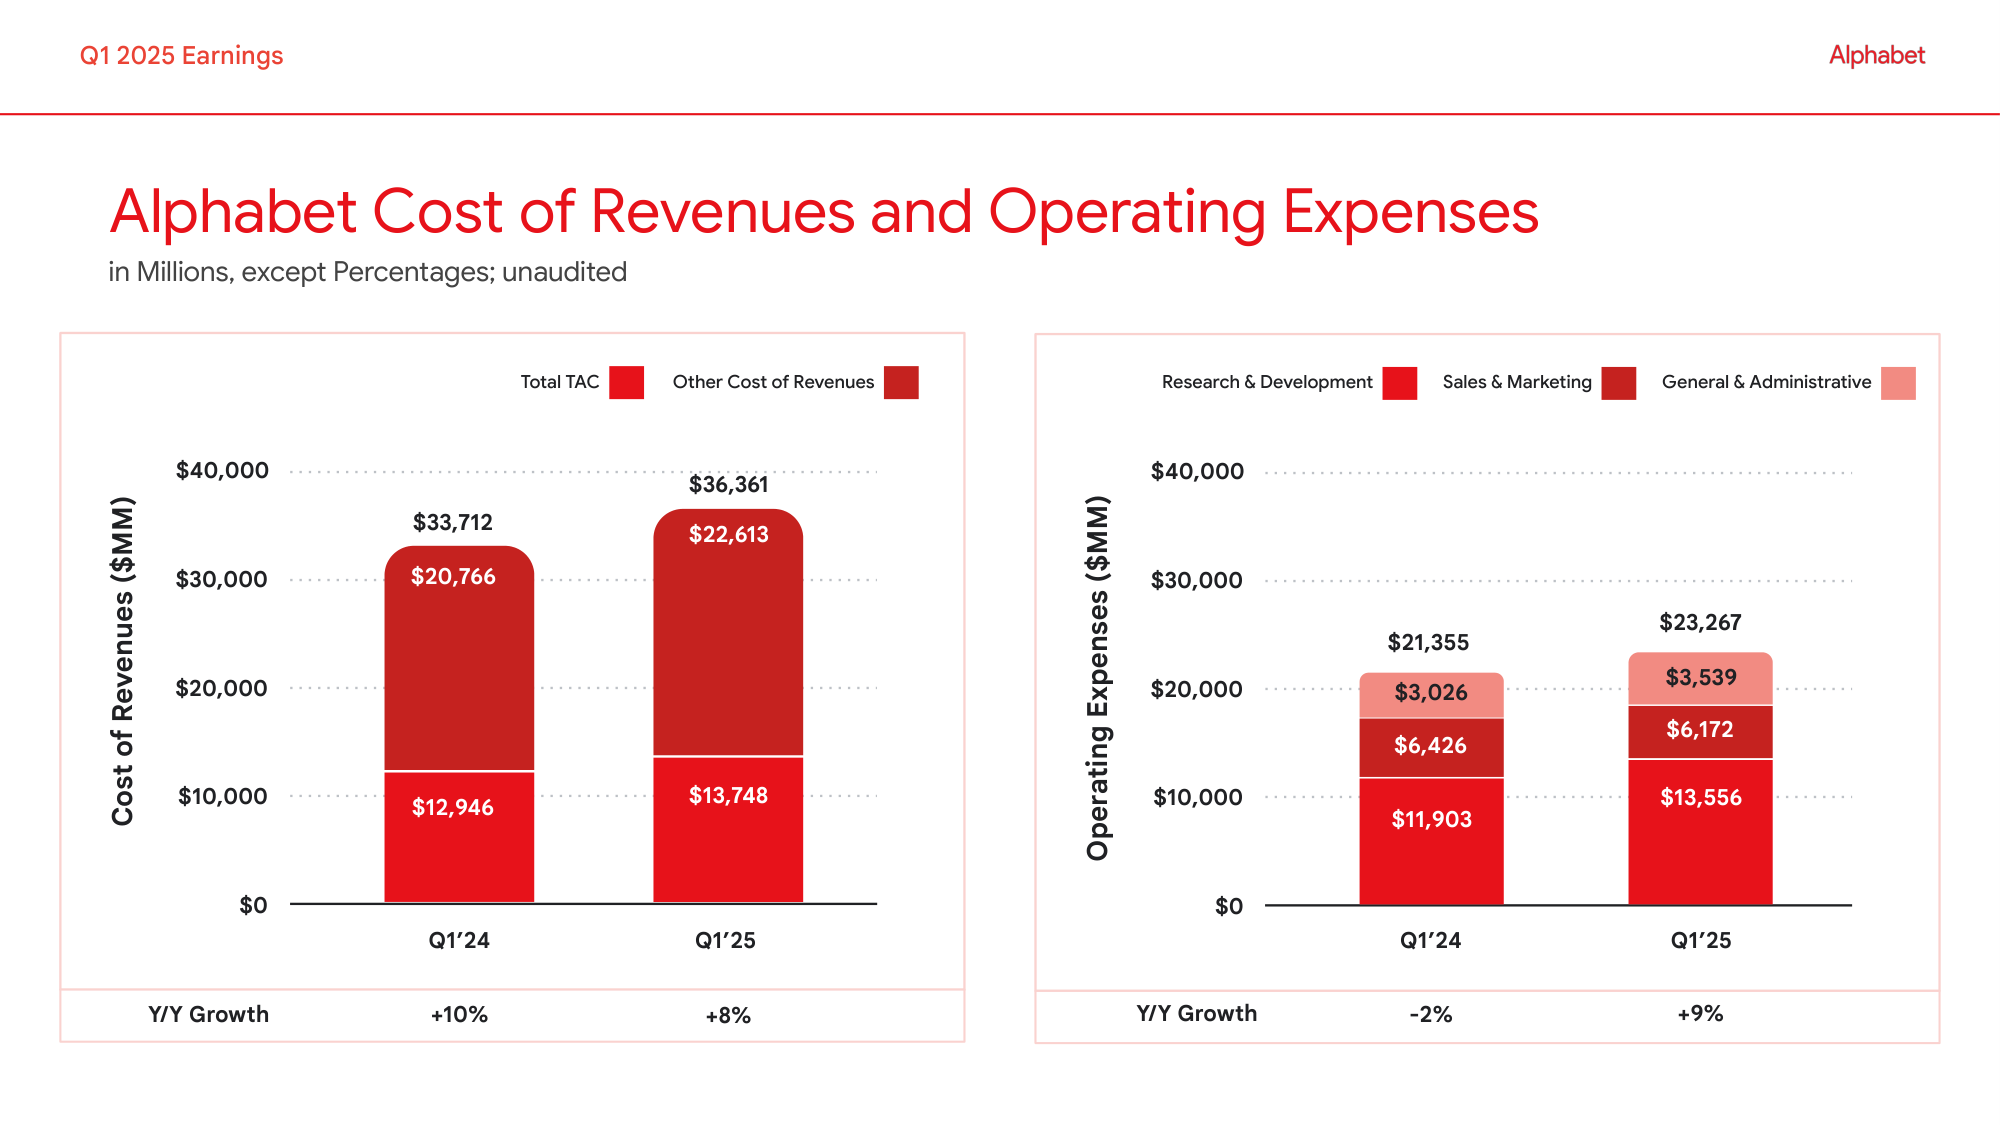

In [20]:
from PIL import Image
IMAGE_INDEX = "00-data/base/faiss_image_index"
IMAGE_META  = "00-data/base/faiss_image_metadata.json"

image_retriever = ImageRetriever(IMAGE_INDEX, IMAGE_META)
query = "What are the operating expenses?"
results = image_retriever.search(query, k=5)
results
path = results[0]["metadata"]["image_path"]
Image.open(path)


## Unified Agent Query Response

In [21]:
# from UnifiedCFOAgent import create_cfo_agent

# agent = create_cfo_agent()

# query = "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."

# # response = agent.invoke({"input": query})

# response = agent.invoke({"input": query}, return_intermediate_steps=True)

# print(response)


In [1]:
import os

print("Folders in sections:")
print(os.listdir("00-data/sections"))

print("\nFiles inside acquisitions folder:")
print(os.listdir("00-data/sections/acquisitions"))


Folders in sections:
['acquisitions', 'balance_sheet', 'cash_flow', 'controls_procedures', 'costs_and_expenses', 'cover_page', 'equity', 'exhibits', 'financial_statements', 'income_statement', 'legal_proceedings', 'market_risk_disclosures', 'mdna', 'risk_factors', 'segment_info', 'signatures', 'summary_financial_data']

Files inside acquisitions folder:
[]


In [1]:
from UnifiedCFOAgent import query_cfo_agent
question = "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response["answer"])
print(response["metadata"])

c:\Users\Admin\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cache MISS

[INFO] Initializing FAISS indices from disk...
[TextSectionRetriever] Loaded 15 section indices from 00-data\sections
[TextSectionRetriever] Searching sections: ['income_statement', 'financial_statements', 'mdna', 'summary_financial_data']
[TextSectionRetriever] Using k=40 for query: 'Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.'
[INFO] Searching 4 sections for: 'Show operating expenses (also referred to as "SG&A", "selling, general and administrative expenses", "total expenses", or "operating costs") for the last 3 fiscal years and provide a year-over-year comparison. Include data from both annual and quarterly periods (e.g., "fiscal year", "year ended", "quarter ended") as reported in the "Consolidated Statements of Income" or "Statements of Operations". Retrieve all relevant line items and synonyms related to operating expenses for comprehensive coverage.'
[INFO] FAISS indices already initialized, reusing existing indices.
[INFO] Complete

c:\Users\Admin\Documents\GitHub\PTO\UnifiedCFOAgent.py:190: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(




> Entering new AgentExecutor chain...
Question: Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.
Thought: To provide operating expenses for the last 3 fiscal years and a year-on-year comparison, I need to retrieve financial tables that include operating expenses data from the company's annual or quarterly filings.
Action: retrieve_table
Action Input: Operating Expenses last 3 fiscal years
Observation: {"query": "Operating Expenses last 3 fiscal years", "answer": "To determine the operating expenses for the last three fiscal years, we will focus on the General and Administrative (G&A) expenses as provided in the retrieved data. The data for G&A expenses for the fiscal years 2021, 2022, and 2023 is available. Here is a summary table of the G&A expenses for these years:\n\n| Fiscal Year | General and Administrative Expenses (in millions) | Source                      |\n|-------------|---------------------------------------------------|----------------------

In [4]:
question = "What is the operating expense for the last 3 fiscal years, year-on-year comparison."
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response["answer"])
print(response["metadata"])

Cache HIT:
  Similarity: 0.9201
  Cached Query: Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.

### General and Administrative Expenses (Operating Expenses Proxy) for the Last 3 Fiscal Years (in millions)

| Year | G&A Expenses | 
|-------|--------------|
| 2021  | $13,510      |
| 2022  | $15,724      |
| 2023  | $16,425      |

### Year-on-Year Comparison

1. From 2021 to 2022:  
   - Increase of 16.38%  
   - Indicates a significant rise in operating costs.

2. From 2022 to 2023:  
   - Increase of 4.46%  
   - Shows continued but slower growth in operating expenses.

### Summary
Operating expenses have consistently increased over the past three years, with a notable spike from 2021 to 2022 and a more moderate increase from 2022 to 2023, suggesting a slowing rate of growth in operating costs.
{'sources': ['goog-10-q-q2-2025', 'goog-10-q-q1-2025', 'goog-10-q-q3-2022', 'goog-10-k-2022', 'goog-10-q-q1-2023', 'goog-10-k-2023-final', 'goog-10-q-q1-2024', 'g

In [5]:
question = "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working."
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response)

Cache MISS

[INFO] FAISS indices already initialized, reusing existing indices.
[TextSectionRetriever] Loaded 3 section indices from 00-data\sections


> Entering new AgentExecutor chain...
Question: Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working.
Thought: To calculate the Operating Efficiency Ratio for the last 3 fiscal years, I need the Operating Expenses (Opex) and Operating Income for each of those years. I will first retrieve a financial table that includes Opex and Operating Income for the last 3 fiscal years.
Action: retrieve_table
Action Input: Operating Expenses and Operating Income for the last 3 fiscal years
Observation: {"query": "Operating Expenses and Operating Income for the last 3 fiscal years", "answer": "To address your query regarding the Operating Expenses and Operating Income for the last three fiscal years, we will extract and calculate the necessary data from the provided documents.\n\n### Opera

In [ ]:
question = "What are the operating expenses?"
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response)

Cache MISS

[INFO] FAISS indices already initialized, reusing existing indices.
[TextSectionRetriever] Loaded 15 section indices from 00-data\sections


> Entering new AgentExecutor chain...
To find the operating expenses, I should retrieve the relevant financial table that contains this information. 
Action: retrieve_table 
Action Input: "operating expenses" 
Observation: {"query": "operating expenses", "answer": "To address the query regarding operating expenses, we will focus on the General and Administrative (G&A) expenses as they are a component of operating expenses. We will analyze the data provided for the first two quarters of 2025 and compare it with the corresponding periods in 2024.\n\n### General and Administrative Expenses Analysis\n\n#### Q1 2025 vs. Q1 2024\n- **Q1 2025 G&A Expenses**: $3,539 million\n- **Q1 2024 G&A Expenses**: $3,026 million\n\n**Calculation of Change:**\n\\[ \\text{Change} = \\frac{\\text{Q1 2025} - \\text{Q1 2024}}{\\text{Q1 2024}} \\times 100 \\]\n

In [ ]:
question = "Where can i get a graphic representation of the operating expenses?"
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response)

In [1]:
from UnifiedCFOAgent import query_cfo_agent
question = "Summarize management's discussion about operating cost trends. Display any relevant images, text and tables."
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response["answer"])
print(response["metadata"])

Cache MISS

[INFO] Initializing FAISS indices from disk...
[TextSectionRetriever] Loaded 15 section indices from 00-data\sections

[PARALLEL] Starting parallel retrieval...
[RETRIEVE_IMAGE] Retrieved 5 images.

[TextSectionRetriever] Searching sections: ['mdna', 'income_statement']
[TextSectionRetriever] Using k=40 for query: 'Summarize management's discussion about operating cost trends. Display any relevant images, text and tables.'
[INFO] Searching 2 sections for: 'Summarize management’s discussion of operating cost trends, including references to operating expenses, SG&A, total expenses, and cost of revenues. Search for relevant text, tables, and images in the “Management’s Discussion and Analysis” (MD&A) section, as well as in “Consolidated Statements of Income” or “Statements of Operations” for both annual (fiscal year) and quarterly (quarter ended) periods. Include synonyms and related terms to capture all discussions of expense trends and cost drivers.'
[INFO] FAISS indices alr

c:\code\PTO-Group\UnifiedCFOAgent.py:188: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(




> Entering new AgentExecutor chain...
Thought: To summarize management's discussion about operating cost trends, I need to retrieve textual evidence from the latest annual or quarterly filings where management discusses operating expenses. Additionally, I should look for any financial tables that show operating expenses or cost trends over time. Finally, I will check for any presentation slides that might visually summarize these trends.

Action: retrieve_text
Action Input: management discussion operating cost trends
[TextSectionRetriever] Searching sections: ['mdna', 'income_statement', 'financial_statements']
[TextSectionRetriever] Using k=40 for query: 'management discussion operating cost trends
'
[INFO] Searching 3 sections for: 'Expanded query:

Search for "Management’s Discussion and Analysis" or "MD&A" sections discussing "operating costs", "operating expenses", "SG&A", "selling, general and administrative expenses", or "total expenses" trends. Include both "fiscal year", "an

In [1]:
from UnifiedCFOAgent import query_cfo_agent
question = "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working."
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response["answer"])
print(response["metadata"])

Cache MISS

[INFO] Initializing FAISS indices from disk...
[TextSectionRetriever] Loaded 15 section indices from 00-data\sections

[PARALLEL] Starting parallel retrieval...
[RETRIEVE_IMAGE] Retrieved 5 images.

[TextSectionRetriever] Searching sections: ['income_statement']
[TextSectionRetriever] Using k=40 for query: 'Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working.'
[INFO] Searching 1 sections for: 'Retrieve "operating expenses", "Opex", "SG&A", "selling, general and administrative expenses", and "total expenses" as reported in "Consolidated Statements of Income", "Statements of Operations", or "Income Statement" for the last 3 fiscal years and quarters ("fiscal year", "year ended", "quarter ended"). Also extract "operating income", "income from operations", or "operating profit" for the same periods. Provide figures and calculations for the Operating Efficiency Ratio (operating expenses divided by operating income) 

c:\code\PTO-Group\UnifiedCFOAgent.py:188: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(




> Entering new AgentExecutor chain...
Question: Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working.
Thought: To calculate the Operating Efficiency Ratio for the last 3 fiscal years, I need the Operating Expenses (Opex) and Operating Income for each of those years. I will first retrieve a financial table containing Opex and Operating Income for the last 3 fiscal years.
Action: retrieve_table
Action Input: Operating Expenses and Operating Income for the last 3 fiscal years[RETRIEVE_TABLE] Completed table retrieval.


Observation: {"query": "Operating Expenses and Operating Income for the last 3 fiscal years", "answer": "To address the query regarding Operating Expenses and Operating Income for the last three fiscal years, we will extract and calculate the necessary data from the provided documents.\n\n### Operating Expenses\n\nOperating expenses typically include costs such as General and Administrative (G&A) expenses, Re

John Testing 

In [1]:
from UnifiedCFOAgent import query_cfo_agent

test_queries = [
    "Report the Gross Margin over the last 5 quarters, with values.",
]

# test_queries = [
#     "Report the Gross Margin over the last 5 quarters, with values.",
#     "Report the Gross Margin over the last 5 quarters, with values.",
#     "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.",
#     "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working.",
# ]

results = []

for q in test_queries:
    # With cache
    to_cache_response = query_cfo_agent(
        q,
        cache_threshold=0.85,
        use_cache=True
    )
    # With cache
    cached_response = query_cfo_agent(
        q,
        cache_threshold=0.85,
        use_cache=True
    )
    
    # Without cache
    fresh_response = query_cfo_agent(
        q,
        cache_threshold=0.85,
        use_cache=False
    )
    
    results.append({
        "query": q,
        "first_cached": to_cache_response,
        "cached": cached_response,
        "fresh": fresh_response
    })

for r in results:
    print("••• Query:", r["query"])
    print("  First Cached:", r["first_cached"])
    print("  Cached:", r["cached"])
    print("  Fresh:", r["fresh"])

Cache MISS

[INFO] Initializing FAISS indices from disk...
[TextSectionRetriever] Loaded 15 section indices from 00-data\sections

[PARALLEL] Starting parallel retrieval...
[RETRIEVE_IMAGE] Retrieved 5 images.

[TextSectionRetriever] Searching sections: ['income_statement', 'financial_statements', 'summary_financial_data']
[TextSectionRetriever] Using k=40 for query: 'Report the Gross Margin over the last 5 quarters, with values.'
[INFO] Searching 3 sections for: 'Retrieve "Gross Margin", "Gross Profit", or "Gross Income" figures for the last 5 quarters ("quarter ended", "three months ended") from SEC filings, including both "Consolidated Statements of Income" and "Statements of Operations". Include synonyms such as "gross profit margin" and reference both quarterly and annual periods ("fiscal year", "annual period"). Provide reported values and ensure coverage of all relevant terminology for comprehensive results.'
[INFO] FAISS indices already initialized, reusing existing indices.
[I

d:\PTO\UnifiedCFOAgent.py:225: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(




> Entering new AgentExecutor chain...
Thought: To report the Gross Margin over the last 5 quarters, I need to retrieve financial tables that include quarterly gross margin data.
Action: retrieve_table
Action Input: "Gross Margin last 5 quarters"[RETRIEVE_TABLE] Completed table retrieval.


Observation: {"query": "Gross Margin last 5 quarters", "answer": "To calculate the gross margin for the last five quarters, we need to determine the gross margin for each quarter. Gross margin is calculated using the formula:\n\n\\[ \\text{Gross Margin} = \\frac{\\text{Revenues} - \\text{Cost of Revenues}}{\\text{Revenues}} \\times 100 \\]\n\nLet's calculate the gross margin for each of the last five quarters using the data provided:\n\n### Q1 2025\n- **Revenues:** $90,234 million\n- **Cost of Revenues:** $36,361 million\n\n\\[ \\text{Gross Margin Q1 2025} = \\frac{90,234 - 36,361}{90,234} \\times 100 = \\frac{53,873}{90,234} \\times 100 \\approx 59.7\\% \\]\n\n(Source: goog-10-q-q1-2025, Table 1, 

## 8. Results & Plots

Show baseline vs optimized. Include latency plots (p50/p95) and accuracy tables.

In [ ]:
# TODO: Generate plots with matplotlib
